In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import savemat
from scipy.stats import gaussian_kde
from scipy.io import loadmat
import h5py
import chaospy as cp
import numpoly
import UQpy as uq
import seaborn as sns

In [2]:
### GENERATE MONTE CARLO INPUTS FOR E_hard & E_soft ###
np.random.seed(1)

E_s_mean = 200e6
E_s_range = 100e6
E_h_mean = 200e9
E_h_range = 100e9

rho_s_mean = 1e3
rho_s_range = 5e2
rho_h_mean = 8e3
rho_h_range = 4e3

pr_h_mean = 0.25
pr_h_range = 0.25
pr_s_mean = 0.25
pr_s_range = 0.25

N_MC2 = 100
N_MC3 = 1000
N_MC4 = 10000

# define the distributions of each input, and joint distribution
E_soft_dist = uq.Uniform(loc=E_s_mean-E_s_range, scale=E_s_mean+E_s_range)
E_hard_dist = uq.Uniform(loc=E_h_mean-E_h_range, scale=E_h_mean+E_h_range)
rho_soft_dist = uq.Uniform(loc=rho_s_mean-rho_s_range, scale=rho_s_mean+rho_s_range)
rho_hard_dist = uq.Uniform(loc=rho_h_mean-rho_h_range, scale=rho_h_mean+rho_h_range)
pr_soft_dist = uq.Uniform(loc=pr_s_mean-pr_s_range, scale=pr_s_mean+pr_s_range)
pr_hard_dist = uq.Uniform(loc=pr_h_mean-pr_h_range, scale=pr_h_mean+pr_h_range)

joint_dist = uq.JointIndependent(marginals=[E_soft_dist, E_hard_dist, rho_soft_dist, rho_hard_dist, pr_soft_dist, pr_hard_dist])

In [3]:
### LOAD MATLAB RESULTS ###
E_soft_MC_sets = {}
E_hard_MC_sets = {}
rho_soft_MC_sets = {}
rho_hard_MC_sets = {}
pr_soft_MC_sets = {}
pr_hard_MC_sets = {}
bg_size_MC_sets = {}
bg_top_MC_sets = {}
bg_bottom_MC_sets = {}
joint_sets = {}

set_N = [100, 1000, 10000]
for N in set_N:
    folder_name = 'mc_'+str(N)
    file_suffix = '_mc_uniform_'+str(N)+'.mat'
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)
    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_soft_MC_sets[N] = E_soft_file['E_soft'][:]
    E_hard_MC_sets[N] = E_hard_file['E_hard'][:]
    rho_soft_MC_sets[N] = rho_soft_file['rho_soft'][:]
    rho_hard_MC_sets[N] = rho_hard_file['rho_hard'][:]
    pr_soft_MC_sets[N] = pr_soft_file['poisson_soft'][:]
    pr_hard_MC_sets[N] = pr_hard_file['poisson_hard'][:]
    bg_size_MC_sets[N] = bg_size_file['bg_size'][:]
    bg_top_MC_sets[N] = bg_top_file['bg_top'][:]
    bg_bottom_MC_sets[N] = bg_bottom_file['bg_bottom'][:]

    joint_sets[N] = np.vstack((
        E_soft_MC_sets[N],
        E_hard_MC_sets[N],
        rho_soft_MC_sets[N],
        rho_hard_MC_sets[N],
        pr_soft_MC_sets[N],
        pr_hard_MC_sets[N]
    ))

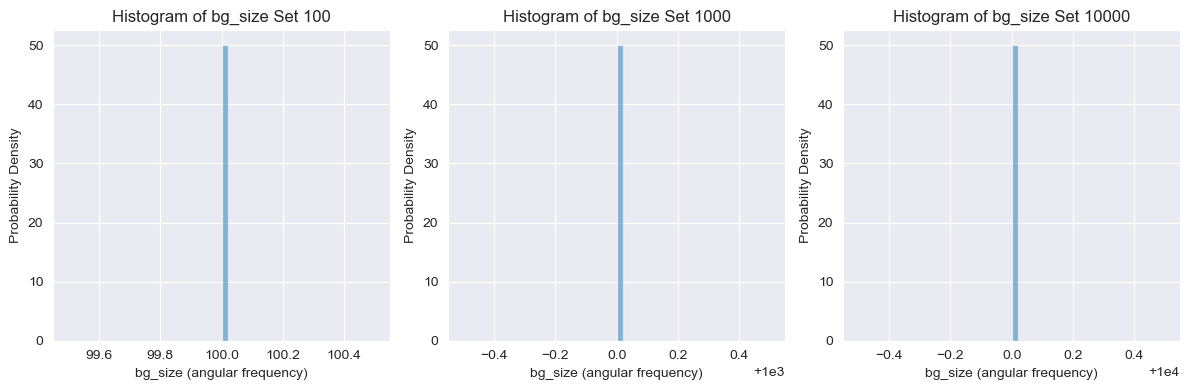

In [4]:
# create subplots for the histograms
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# plot the histograms in each subplot
num_bins = 50
for i, sample_set in bg_size_MC_sets.items():
    ax = axes[i]
    ax.hist(sample_set, bins=50, density=True, alpha=0.5)

    # add labels and a title to the plot
    ax.set_xlabel('bg_size (angular frequency)')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'Histogram of bg_size Set {10**(i+2)}')

plt.tight_layout()


In [9]:
### CREATE POLYNOMIAL BASIS AND FIT TO DATA ###
#collocation_schemes = ["gaussian"]
# degrees = [2, 3, 4, 5]
# sample_set_surrogates = {}
# case = 1
# # create surrogate models of different polynomial orders
# for i, sample_set in joint_sets.items():
#     sc_surrogates = {}
#     collocation_nodes = joint_sets[i].T
#     #collocation_nodes = np.vstack((E_soft_sample_sets[i], E_hard_sample_sets[i]))
#     evaluations = bg_size_MC_sets[i]
#     print(collocation_nodes.shape, evaluations.shape)
#     for degree in degrees:
#         polynomial_basis = uq.TensorProductBasis(distributions=joint_dist, max_degree=degree)
#         least_squares = uq.LeastSquareRegression()
#         pce = uq.PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)
#         pce.fit(x=collocation_nodes, y=evaluations)
#         sc_surrogates[degree] = pce
#     sample_set_surrogates[i] = sc_surrogates
# print(sample_set_surrogates.keys())

(100, 6) (100, 1)
(1000, 6) (1000, 1)
(10000, 6) (10000, 1)
dict_keys([100, 1000, 10000])


KeyError: 0

In [10]:
degrees = [2, 3, 4, 5]
sample_set_surrogates = {}
# create surrogate models of different polynomial orders
N = 100
sc_surrogates = {}
collocation_nodes = joint_sets[N].T
#collocation_nodes = np.vstack((E_soft_sample_sets[i], E_hard_sample_sets[i]))
evaluations = bg_size_MC_sets[N]
print(collocation_nodes.shape, evaluations.shape)
for degree in degrees:
    polynomial_basis = uq.TensorProductBasis(distributions=joint_dist, max_degree=degree)
    least_squares = uq.LeastSquareRegression()
    pce = uq.PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)
    pce.fit(x=collocation_nodes, y=evaluations)
    sc_surrogates[degree] = pce
sample_set_surrogates[N] = sc_surrogates
print(sample_set_surrogates.keys())

(100, 6) (100, 1)
dict_keys([100])


In [17]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 1000
joint_test_mc = joint_dist.rvs(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for degree in degrees:
    mc_surrogate_model = sc_surrogates[degree]
    #print(type(mc_surrogate_model))
    #print(mc_surrogate_model)
    mc_surrogate_outputs[degree] = mc_surrogate_model.predict(joint_test_mc)
    #print(mc_surrogate_outputs[degree])
    #print(mc_surrogate_outputs[degree])
    mc_surrogate_kdes[degree] = gaussian_kde(mc_surrogate_outputs[degree].flatten())
    mc_surrogate_pdf[degree] = mc_surrogate_kdes[degree](np.linspace(np.min(mc_surrogate_outputs[degree]), np.max(mc_surrogate_outputs[degree]), 1000))

Text(0.5, 0.98, 'Bandcap Size Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

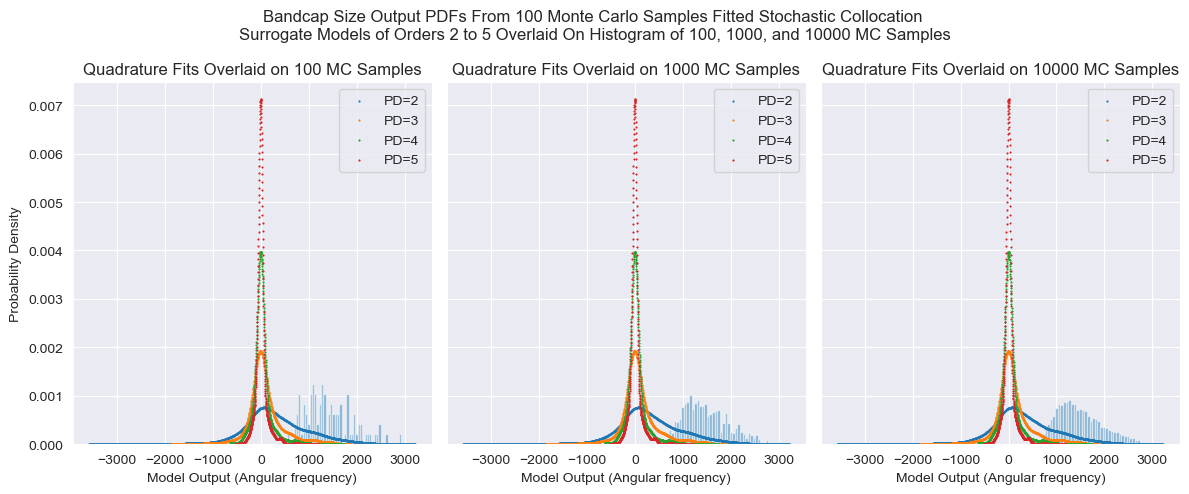

In [18]:
### PLOT SURROGATE PDF CONVERGENCE ###
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in degrees:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[d]), np.max(mc_surrogate_outputs[d]), 1000), mc_surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[d]), np.max(mc_surrogate_outputs[d]), 1000), mc_surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[d]), np.max(mc_surrogate_outputs[d]), 1000), mc_surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Angular frequency)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Angular frequency)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Angular frequency)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandcap Size Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Obsolete Code

In [52]:
### CREATE POLYNOMIAL BASIS AND FIT TO DATA (ONLY E_soft) ###
#collocation_schemes = ["gaussian"]
degrees = [2, 3, 4, 5, 6, 7, 8]
sample_set_surrogates = {}
case = 1
# create surrogate models of different polynomial orders
for i, sample_set in enumerate(E_soft_sample_sets):
    sc_surrogates = {}
    collocation_nodes = E_soft_sample_sets[i]
    evaluations = bg_size_sample_sets[i]
    print(collocation_nodes.shape, evaluations.shape)
    for degree in degrees:
        polynomial_basis = uq.TotalDegreeBasis(distributions=E_soft_dist, max_degree=degree)
        least_squares = uq.LeastSquareRegression()
        pce = uq.PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)
        pce.fit(x=collocation_nodes, y=evaluations)
        sc_surrogates[degree] = pce
    sample_set_surrogates[i] = sc_surrogates
print(sample_set_surrogates.keys())
print(sample_set_surrogates[0].keys())

(100, 1) (100, 1)
(1000, 1) (1000, 1)
(10000, 1) (10000, 1)
dict_keys([0, 1, 2])
dict_keys([2, 3, 4, 5, 6, 7, 8])


In [53]:
N_test = 1000
E_test = E_soft_dist.rvs(N_test)
print(E_test.shape)

surrogate_outputs = np.zeros((len(sample_set_surrogates),len(degrees),N_test))
surrogate_kdes = [None]*len(surrogate_outputs)
surrogate_pdf = np.zeros(shape=surrogate_outputs.shape)
order_offset = 2
print(surrogate_outputs.shape, len(surrogate_kdes), surrogate_pdf.shape)
for sample_set, models in sample_set_surrogates.items():
    #print(sample_set)
    surrogate_kdes[sample_set] = [None]*len(sample_set_surrogates[sample_set])
    for degree, model in models.items():
        #print(sample_set, degree)
        #print(model, type(model))
        surrogate_outputs[sample_set][degree-order_offset] = model.predict(E_test).flatten()
        surrogate_kdes[sample_set][degree-order_offset] = gaussian_kde(surrogate_outputs[sample_set][degree-order_offset])
        surrogate_pdf[sample_set][degree-order_offset] = surrogate_kdes[sample_set][degree-order_offset](np.linspace(np.min(surrogate_outputs[sample_set][degree-order_offset]), np.max(surrogate_outputs[sample_set][degree-order_offset]), 1000))

(1000, 1)
(3, 7, 1000) 3 (3, 7, 1000)


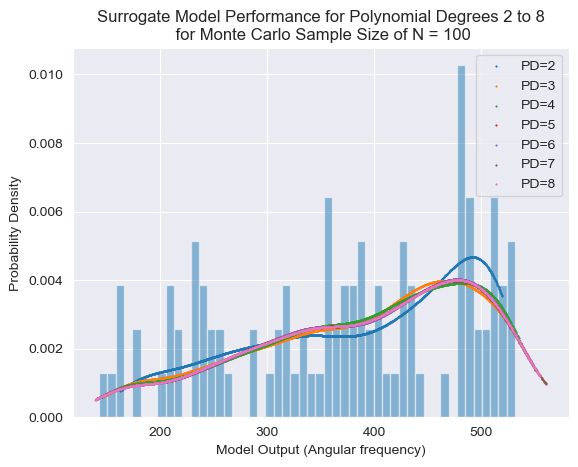

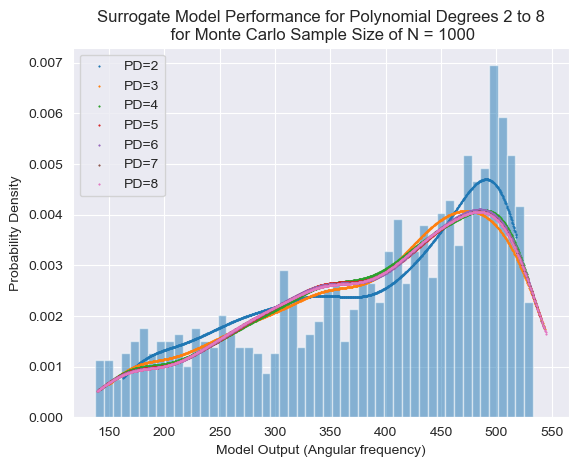

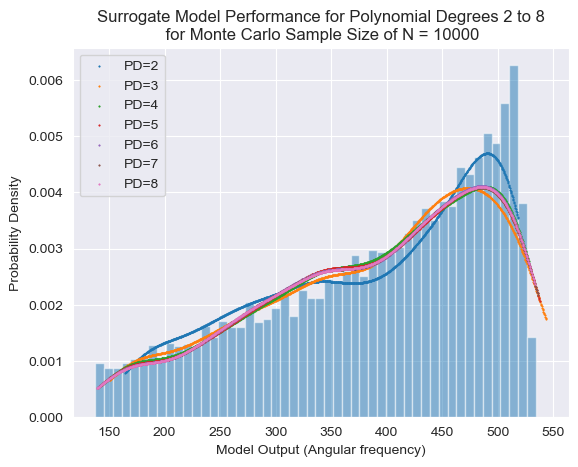

In [54]:
### PLOT SURROGATE PDF CONVERGENCE ###
for i, sample_set in enumerate(bg_size_sample_sets):
    plt.figure()
    plt.hist(sample_set, bins=50, density=True, alpha=0.5)
    for d_o, pdf in enumerate(surrogate_pdf[i]):
        plot_label = 'PD='+str(d_o+order_offset)
        plt.scatter(np.linspace(np.min(surrogate_outputs[i][d_o]), np.max(surrogate_outputs[i][d_o]), 1000), pdf, label=plot_label, s=1, linewidths=0.5)
    plt.xlabel("Model Output (Angular frequency)")
    plt.ylabel("Probability Density")
    title_str = 'Surrogate Model Performance for Polynomial Degrees 2 to 8\n for Monte Carlo Sample Size of N = '+ str(10**(i+2))
    plt.title(title_str)
    plt.legend(loc='best')

In [76]:
N_test = 2000
E_soft_uniform_test_2000 = E_soft_dist.rvs(N_test)
savemat('E_soft_uniform_test_'+str(len(E_soft_uniform_test_2000))+'.mat', {'E_soft': sample_set})

In [78]:
bg_size_uniform_test_2000_file = loadmat('bg_size_uniform_test_2000.mat')
bg_size_uniform_test_2000 = bg_size_uniform_test_2000_file['bg_size'][:]

In [79]:
bg_size_uniform_test_2000_surrogate_outputs = {}
for degree, model in sample_set_surrogates[2].items():
    #print(model, type(model))
    bg_size_uniform_test_2000_surrogate_outputs[degree] = model.predict(E_soft_uniform_test_2000).flatten()

Text(0, 0.5, 'Surrogate Model Output')

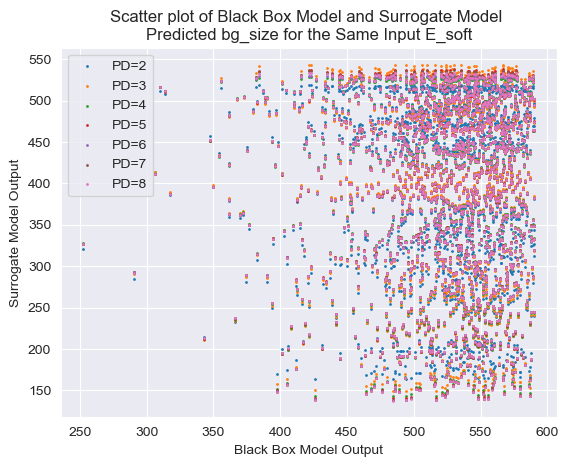

In [93]:
plt.figure()
for degree, predictions in bg_size_uniform_test_2000_surrogate_outputs.items():
    plt.scatter(bg_size_uniform_test_2000, predictions, label=('PD='+str(degree)) ,s=1)

plt.legend(loc='best')
plt.title('Scatter plot of Black Box Model and Surrogate Model \nPredicted bg_size for the Same Input E_soft')
plt.xlabel('Black Box Model Output')
plt.ylabel('Surrogate Model Output')

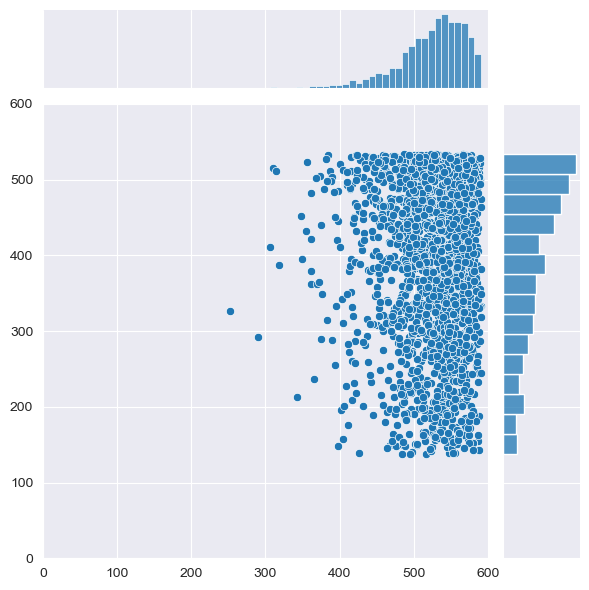

In [95]:
import seaborn as sns

# Create the scatter plot with marginal histograms
sns.jointplot(x=bg_size_uniform_test_2000.flatten(), y=bg_size_uniform_test_2000_surrogate_outputs[8].flatten(), kind='scatter', xlim=(0, 600), ylim=(0, 600))